# The Role of Summary Statistics in SBI

**Time: ~20 minutes**

In Notebook 3, we learned how to use the `sbi` toolbox for Neural Posterior Estimation. Now we'll explore a crucial question:

> **How do summary statistics affect the quality of our inference?**

In simulation-based inference, we often need to compress high-dimensional simulator outputs (like time series) into lower-dimensional summary statistics. The choice of summary statistics can dramatically impact inference quality!

## What We'll Explore

1. **Simple statistics**: Mean, std, max, skew, kurtosis (10 summary stats)
2. **Advanced statistics**: Adding autocorrelation to capture temporal dynamics (20 summary stats)
3. **Neural embedding**: Let a neural network learn the summary statistics directly from raw time series

**Key insight**: More informative summary statistics → tighter posteriors → better parameter recovery!

**Documentation**: [sbi.readthedocs.io](https://sbi.readthedocs.io/)

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CausalCNNEmbedding

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

/mnt/lustre/work/macke/mwe054/repos/sbi-hackathon-2026/.venv/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


---
## Setup: The Lotka-Volterra Predator-Prey Model

We continue working with the Lotka-Volterra model from the previous notebooks. This model describes the dynamics of a predator-prey ecosystem with 4 parameters.

In [2]:
# Setup the prior (same for all experiments)
prior = create_lotka_volterra_prior()

# True parameters for our "observed" data
_, theta_o = generate_observed_data()  # theta_o = [0.1, 0.02, 0.01, 0.1]


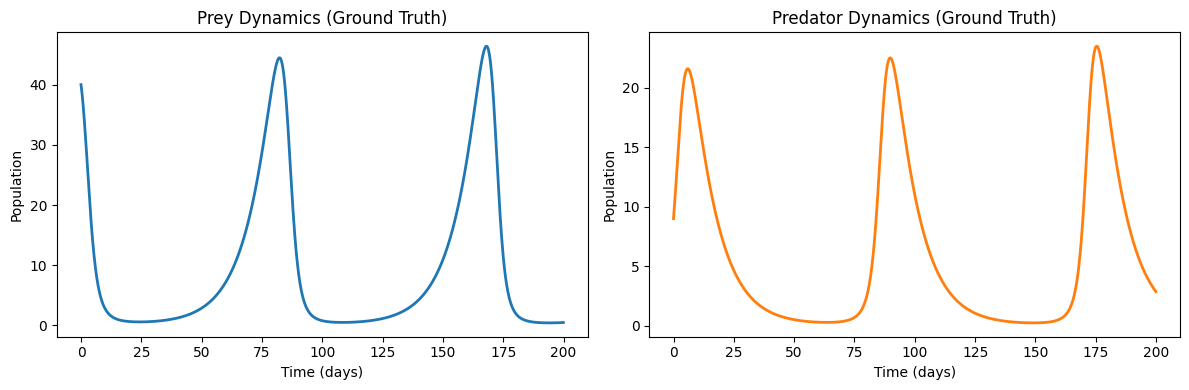

Time series length: 2000 time points
!! The challenge: How do we compress this into informative summary statistics? !!


In [3]:
# Visualize the "ground truth" time series
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_o.numpy())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(time, ts_observed[:, 0], color="C0", linewidth=2)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Prey Dynamics (Ground Truth)")

ax = axes[1]
ax.plot(time, ts_observed[:, 1], color="C1", linewidth=2)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Predator Dynamics (Ground Truth)")

plt.tight_layout()
plt.show()

print(f"Time series length: {len(ts_observed)} time points")
print("!! The challenge: How do we compress this into informative summary statistics? !!")

In [4]:
# Helper function for posterior predictive visualization
def plot_posterior_predictive(samples, theta_o, ts_observed, time, n_samples=50, title=""):
    """Plot posterior predictive simulations vs ground truth."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Sample some posterior parameters and simulate
    indices = np.random.choice(len(samples), size=n_samples, replace=False)

    for idx in indices:
        theta_sample = samples[idx].numpy()
        ts_sample = simulate(theta_sample)
        axes[0].plot(time, ts_sample[:, 0], color="C0", alpha=0.15, linewidth=0.5)
        axes[1].plot(time, ts_sample[:, 1], color="C1", alpha=0.15, linewidth=0.5)

    # Plot ground truth
    axes[0].plot(time, ts_observed[:, 0], color="black", linewidth=2, label="Ground truth")
    axes[1].plot(time, ts_observed[:, 1], color="black", linewidth=2, label="Ground truth")

    # Formatting
    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Population")
    axes[0].set_title(f"Prey - {title}")
    axes[0].legend()
    axes[0].plot([], [], color="C0", alpha=0.5, label="Posterior samples")
    axes[0].legend()

    axes[1].set_xlabel("Time (days)")
    axes[1].set_ylabel("Population")
    axes[1].set_title(f"Predator - {title}")
    axes[1].plot([], [], color="C1", alpha=0.5, label="Posterior samples")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

---
## Think First!

Before we start experimenting, let's think about summary statistics:

**Question 1**: Why do we need summary statistics in SBI? Why not use the raw time series directly?

**Question 2**: What properties should "good" summary statistics have?

**Question 3**: What information might simple statistics (mean, std, max) miss about oscillatory dynamics?

<details>
<summary>Click to reveal answers</summary>

1. **Why summary statistics?**
   - Raw simulator output can be very high-dimensional (e.g., 2000 time points × 2 populations = 4000 dimensions!)
   - Neural networks struggle with such high-dimensional inputs
   - Well-chosen summary statistics can capture the essential information in a compact form
   - However: poor summary statistics can lose crucial information!

2. **Good summary statistics should:**
   - Be **sufficient**: capture all information relevant for distinguishing parameters
   - Be **low-dimensional**: easier for the neural network to learn
   - Be **robust**: not too sensitive to noise
   - Be **informative**: different parameters should produce different statistics

3. **What simple statistics miss:**
   - **Temporal structure**: mean/std don't capture oscillation frequency or phase
   - **Autocorrelation**: how values at time t relate to values at time t+k
   - **Periodicity**: the characteristic period of the predator-prey cycles
   - This is why we'll add autocorrelation features as "advanced" statistics!

</details>

---
## Part 1: Simple Summary Statistics

Let's start with basic summary statistics: **mean, std, max, skew, and kurtosis** for each population.

This gives us **10 summary statistics** total (5 per population).

In [5]:
# Generate observed data with SIMPLE summary statistics (no autocorrelation)
x_o_simple, _ = generate_observed_data(use_autocorrelation=False)

print(f"with x_o_simple we have {x_o_simple.shape[1]} summary statistics")

with x_o_simple we have 10 summary statistics


### Your Task: Train NPE with Simple Statistics

Generate training data and train NPE using the simple summary statistics.

**Hints**:
- Use `lotka_volterra_simulator(theta, use_autocorrelation=False)` for simple stats
- Use the same workflow as in Notebook 3: sample → simulate → train → sample posterior

In [6]:
# SOLUTION: Generate training data with simple statistics
num_simulations = 2_000

# TODO: Sample parameters from the prior
# theta_simple = ...
theta_simple = prior.sample((num_simulations,))  # SOLUTION

# TODO: Simulate with simple summary statistics
# x_simple = ...
x_simple = lotka_volterra_simulator(theta_simple, use_autocorrelation=False)  # SOLUTION

print(f"Training data shapes: theta={theta_simple.shape}, x={x_simple.shape}")

Training data shapes: theta=torch.Size([2000, 4]), x=torch.Size([2000, 10])


In [7]:
# SOLUTION: Train NPE with simple statistics
# TODO: Create NPE, append simulations, and train
# npe_simple = ...
npe_simple = NPE(prior)  # SOLUTION
npe_simple.append_simulations(theta_simple, x_simple).train()  # SOLUTION

# TODO: Build posterior and sample
# posterior_simple = ...
# samples_simple = ...
posterior_simple = npe_simple.build_posterior()  # SOLUTION
samples_simple = posterior_simple.sample((10_000,), x=x_o_simple)  # SOLUTION

print(f"Posterior samples shape: {samples_simple.shape}")

 Training neural network. Epochs trained: 10

 Neural network successfully converged after 363 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]

Posterior samples shape: torch.Size([10000, 4])


### Evaluate Part 1: How good are our results?

Let's visualize the posterior and check if simulations from posterior samples match the observed data.

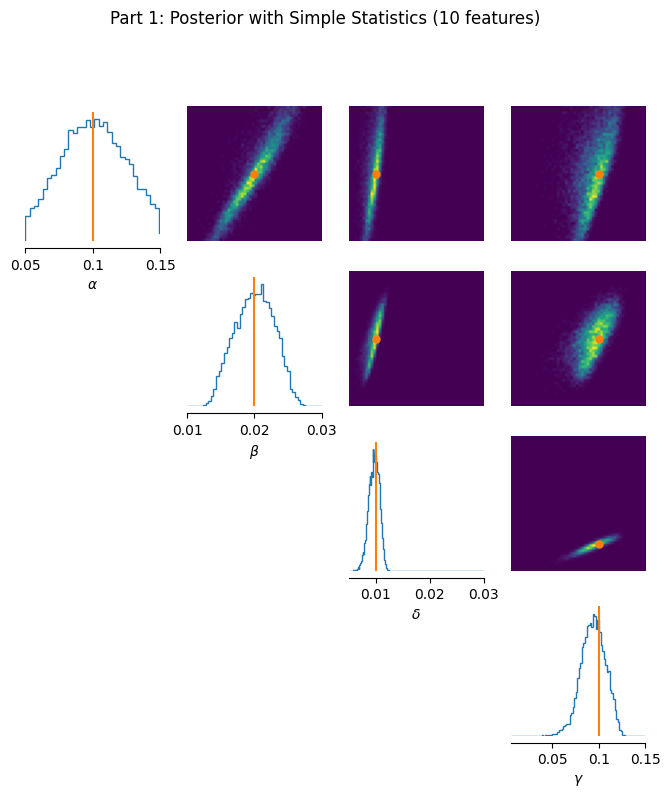

In [8]:
# Pairplot for Part 1: Simple Statistics
param_labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
limits = [[0.05, 0.15], [0.01, 0.03], [0.005, 0.03], [0.005, 0.15]]

fig, axes = pairplot(
    samples_simple,
    limits=limits,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,
)
plt.suptitle("Part 1: Posterior with Simple Statistics (10 features)", y=1.02)
plt.show()

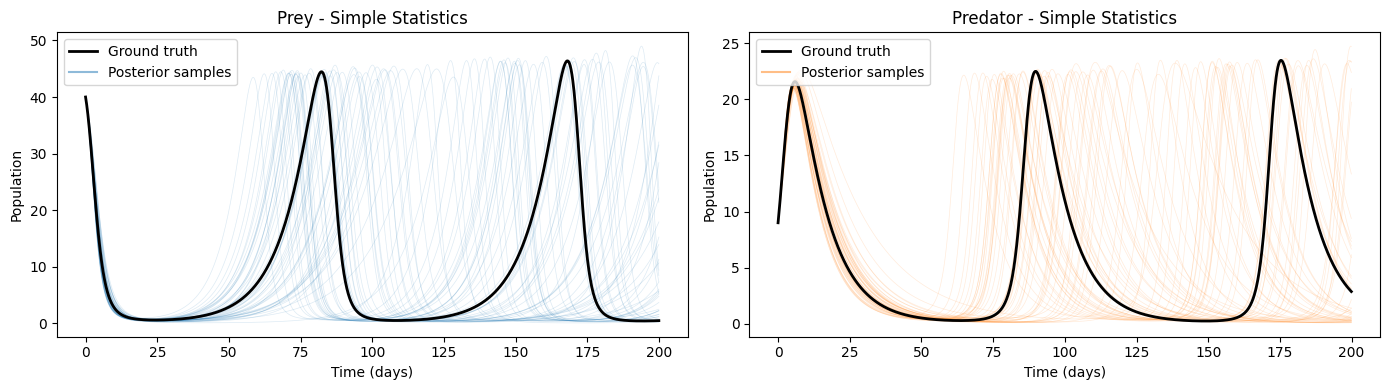

Notice: The posterior is quite broad - many different dynamics are plausible!
This is because simple statistics don't capture the oscillation patterns.


In [9]:
# Posterior Predictive Check for Part 1
# Do simulations from the posterior match the observed time series?
plot_posterior_predictive(
    samples_simple, theta_o, ts_observed, time,
    n_samples=50, title="Simple Statistics"
)
print("Notice: The posterior is quite broad - many different dynamics are plausible!")
print("This is because simple statistics don't capture the oscillation patterns.")

---
## Part 2: Advanced Summary Statistics (with Autocorrelation)

The Lotka-Volterra model produces **oscillatory dynamics**. Simple statistics like mean and std don't capture the temporal structure!

Let's add **autocorrelation** features that measure how the time series correlates with itself at different time lags. This captures:
- The period of oscillations
- How quickly correlations decay
- The temporal dynamics that distinguish different parameter settings

This gives us **20 summary statistics** total (10 per population: 5 moments + 5 autocorrelation lags).

In [10]:
# Generate observed data with ADVANCED summary statistics (with autocorrelation)
x_o_advanced, _ = generate_observed_data(use_autocorrelation=True)

print(f"with x_o_advanced we have {x_o_advanced.shape[1]} summary statistics")

with x_o_advanced we have 20 summary statistics


### Your Task: Train NPE with Advanced Statistics

Now train NPE using the advanced summary statistics with autocorrelation.

**Hint**: Change `use_autocorrelation=True` in the simulator call.

In [11]:
# SOLUTION: Generate training data with advanced statistics
# TODO: Sample and simulate with autocorrelation
# theta_advanced = ...
# x_advanced = ...
theta_advanced = prior.sample((num_simulations,))  # SOLUTION
x_advanced = lotka_volterra_simulator(theta_advanced, use_autocorrelation=True)  # SOLUTION

print(f"Training data shapes: theta={theta_advanced.shape}, x={x_advanced.shape}")

Training data shapes: theta=torch.Size([2000, 4]), x=torch.Size([2000, 20])


In [12]:
# SOLUTION: Train NPE with advanced statistics
# TODO: Create NPE, train, build posterior, and sample
# npe_advanced = ...
# posterior_advanced = ...
# samples_advanced = ...
npe_advanced = NPE(prior)  # SOLUTION
npe_advanced.append_simulations(theta_advanced, x_advanced).train()  # SOLUTION
posterior_advanced = npe_advanced.build_posterior()  # SOLUTION
samples_advanced = posterior_advanced.sample((10_000,), x=x_o_advanced)  # SOLUTION

print(f"Posterior samples shape: {samples_advanced.shape}")

 Neural network successfully converged after 342 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]

Posterior samples shape: torch.Size([10000, 4])


### Evaluate Part 2: Did autocorrelation help?

Let's see if adding temporal information (autocorrelation) improves our inference.

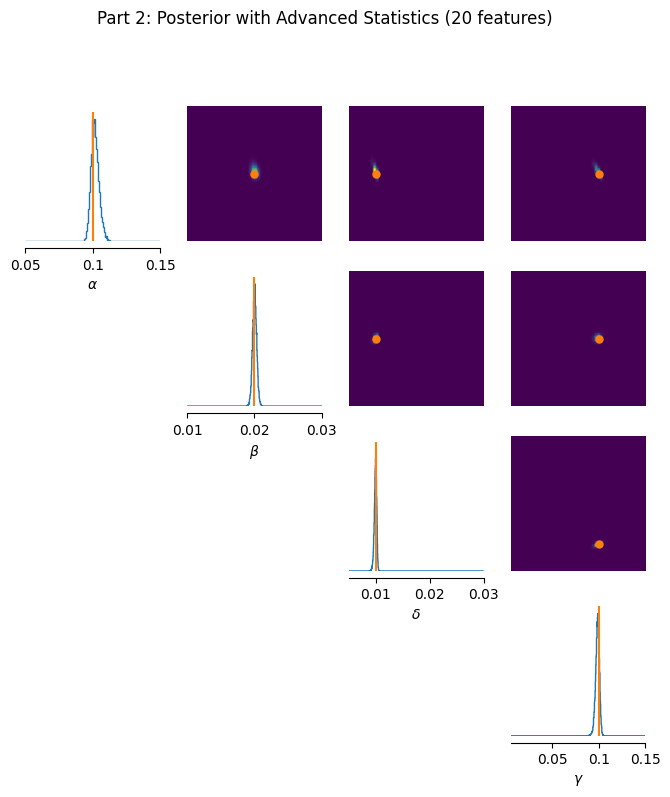

In [13]:
# Pairplot for Part 2: Advanced Statistics
fig, axes = pairplot(
    samples_advanced,
    limits=limits,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,
)
plt.suptitle("Part 2: Posterior with Advanced Statistics (20 features)", y=1.02)
plt.show()

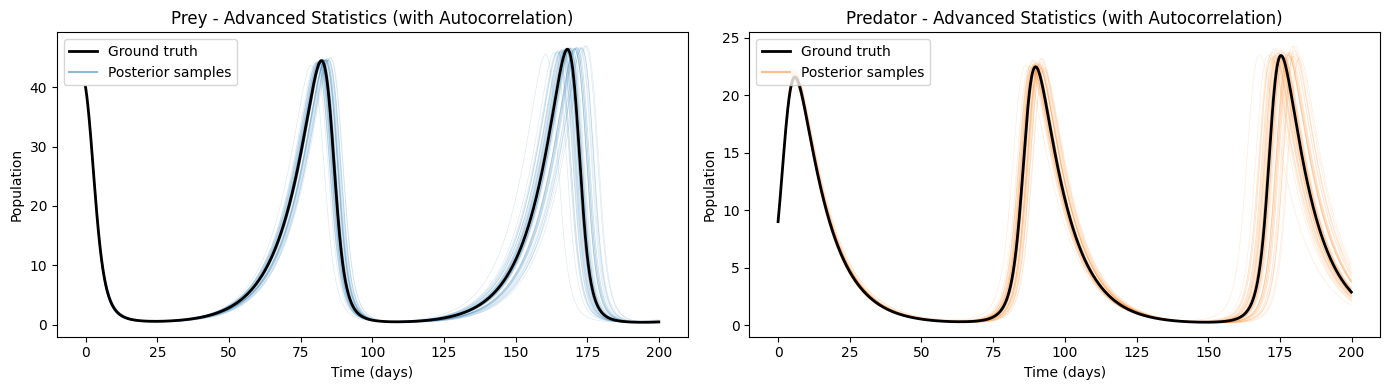

Much better! The posterior samples now capture the oscillation patterns.
Autocorrelation features helped the network understand temporal dynamics.


In [14]:
# Posterior Predictive Check for Part 2
plot_posterior_predictive(
    samples_advanced, theta_o, ts_observed, time,
    n_samples=50, title="Advanced Statistics (with Autocorrelation)"
)
print("Much better! The posterior samples now capture the oscillation patterns.")
print("Autocorrelation features helped the network understand temporal dynamics.")

---
## Part 3: Neural Embedding Networks (Learning Summary Statistics)

What if we could **learn** the summary statistics directly from data?

Instead of hand-crafting summary statistics, we can use a **neural embedding network** that:
1. Takes the raw time series as input
2. Learns to compress it into informative features
3. Feeds those features to the posterior estimator

The posterior approximation becomes: $q_\phi\big(\theta \mid f_\lambda(x_o)\big)$ where:
- $\phi$ are the parameters of the density estimator (normalizing flow)
- $\lambda$ are the parameters of the embedding network
- Both are **jointly learned** during training!

### The `sbi` Syntax for Embedding Networks

```python
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CausalCNNEmbedding

# 1. Create the embedding network
embedding_net = CausalCNNEmbedding(input_shape=(...,), in_channels=..., output_dim=...)

# 2. Create the density estimator WITH the embedding
density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)

# 3. Pass to NPE
inferer = NPE(prior=prior, density_estimator=density_estimator)
```

`sbi` provides several pre-configured embedding networks:
- `FCEmbedding`: Fully-connected MLP
- `CNNEmbedding`: Convolutional neural network (for images)
- `CausalCNNEmbedding`: Causal 1D CNN based on WaveNet (for time series) ← **We'll use this!**
- `PermutationInvariantEmbedding`: For iid trial-based data

See: [sbi embedding networks tutorial](https://sbi.readthedocs.io/en/stable/advanced_tutorials/04_embedding_networks.html) and [CausalCNNEmbedding source](https://github.com/sbi-dev/sbi/blob/main/sbi/neural_nets/embedding_nets/causal_cnn.py)

In [15]:
# First, we need a simulator that returns RAW time series (not summary statistics)
# CausalCNNEmbedding expects shape: (batch_size, in_channels, num_timepoints)
def raw_timeseries_simulator(params: torch.Tensor) -> torch.Tensor:
    """Simulate and return raw time series for CausalCNN embedding."""
    params = params.unsqueeze(0) if params.ndim == 1 else params
    # simulate() returns (timepoints, 2) for each parameter set
    # Stack to get (batch, timepoints, channels), then transpose to (batch, channels, timepoints)
    ts = torch.tensor(np.stack([simulate(p.numpy()) for p in params]), dtype=torch.float32)
    return ts.permute(0, 2, 1)  # (batch, channels=2, timepoints=2000)

# Test it
test_ts = raw_timeseries_simulator(theta_o)
print(f"Raw time series shape: {test_ts.shape}")
print("  → (batch_size, in_channels=2, num_timepoints=2000)")

Raw time series shape: torch.Size([1, 2, 2000])
  → (batch_size, in_channels=2, num_timepoints=2000)


### Your Task: Train NPE with Causal CNN Embedding

Now train NPE using the raw time series with a **CausalCNNEmbedding** network.

The CausalCNN is based on the WaveNet architecture and uses dilated causal convolutions to capture temporal patterns at multiple scales.

**Steps**:
1. Generate training data as raw time series (shape: `batch_size × in_channels × num_timepoints`)
2. Create a `CausalCNNEmbedding` network that compresses time series to fixed-size vectors
3. Create the density estimator with: `posterior_nn("maf", embedding_net=...)`
4. Create NPE with: `NPE(prior, density_estimator=...)`
5. Train and sample as usual

**Key parameters for `CausalCNNEmbedding`**:
- `input_shape`: Tuple with number of timepoints, e.g. `(2000,)`
- `in_channels`: Number of input channels (2 for prey + predator)
- `output_dim`: Size of the learned summary representation
- `num_conv_layers`, `kernel_size`: Control network depth and receptive field

In [16]:
# SOLUTION: Generate training data as raw time series
# Note: We use fewer simulations here as training with embeddings is slower
num_simulations_cnn = 2_000

# TODO: Sample parameters
# theta_cnn = ...
theta_cnn = prior.sample((num_simulations_cnn,))  # SOLUTION

# TODO: Simulate raw time series
# x_cnn = ...
x_cnn = raw_timeseries_simulator(theta_cnn)  # SOLUTION

# Also generate observed data as raw time series
x_o_cnn = raw_timeseries_simulator(theta_o)

print(f"Training data shapes: theta={theta_cnn.shape}, x={x_cnn.shape}")
print(f"Observed data shape: {x_o_cnn.shape}")

Training data shapes: theta=torch.Size([2000, 4]), x=torch.Size([2000, 2, 2000])
Observed data shape: torch.Size([1, 2, 2000])


In [17]:
# SOLUTION: Step 1 - Create the CausalCNN embedding network
# The embedding network compresses time series → fixed-size vector
#
# Input shape:  (batch_size, in_channels=2, num_timepoints=2000)
# Output shape: (batch_size, output_dim=20)

# TODO: Create CausalCNN embedding network
# embedding_net = CausalCNNEmbedding(
#     input_shape=...,   # Tuple with number of timepoints
#     in_channels=...,   # Number of input channels
#     output_dim=...,    # Size of learned summary representation
#     ...
# )

embedding_net = CausalCNNEmbedding(  # SOLUTION
    input_shape=(2000,),      # 2000 timepoints
    in_channels=2,            # 2 channels: prey and predator populations
    output_dim=20,            # Compress to 20 learned summary features
    num_conv_layers=5,        # Number of dilated causal conv layers
    kernel_size=2,            # Kernel size for convolutions
)

print(f"CausalCNN Embedding network created!")
print(f"  - Input: time series of shape (batch, 2, 2000)")
print(f"  - Output: embedding of shape (batch, 20)")
print(f"  - Total parameters: {sum(p.numel() for p in embedding_net.parameters()):,}")

(16, 12)
(64, 6)
(20, 3)
CausalCNN Embedding network created!
  - Input: time series of shape (batch, 2, 2000)
  - Output: embedding of shape (batch, 20)
  - Total parameters: 17,892


In [18]:
# SOLUTION: Step 2 - Create density estimator WITH the embedding network
# The embedding_net is passed to posterior_nn() and will be jointly trained!

# TODO: Create the neural density estimator with embedding
# density_estimator = posterior_nn(model="maf", embedding_net=...)

density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)  # SOLUTION

# SOLUTION: Step 3 - Create NPE with the custom density estimator
# TODO: Create NPE inference object
# npe_cnn = NPE(prior=prior, density_estimator=...)

npe_cnn = NPE(prior=prior, density_estimator=density_estimator)  # SOLUTION

# SOLUTION: Step 4 - Train (embedding and flow are learned jointly!)
print("Training NPE with CausalCNN embedding...")
print("(The embedding network learns to extract informative features from raw time series)")
npe_cnn.append_simulations(theta_cnn, x_cnn).train(max_num_epochs=100)

Training NPE with CausalCNN embedding...
(The embedding network learns to extract informative features from raw time series)


 Training neural network. Epochs trained: 101

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
            (context_layer): Linear(in_features=20, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=8, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
            (context_layer): Linear(in_featur

In [19]:
# SOLUTION: Step 5 - Build posterior and sample
# Note: We pass the RAW time series x_o_cnn - the embedding network handles compression!

posterior_cnn = npe_cnn.build_posterior()  # SOLUTION
samples_cnn = posterior_cnn.sample((10_000,), x=x_o_cnn)  # SOLUTION

print(f"Posterior samples shape: {samples_cnn.shape}")
print(f"\nThe CausalCNN embedding automatically compressed the {x_o_cnn.shape[-1]}-step time series")
print(f"into a 20-dimensional learned summary!")

  0%|          | 0/10000 [00:00<?, ?it/s]

Posterior samples shape: torch.Size([10000, 4])

The CausalCNN embedding automatically compressed the 2000-step time series
into a 20-dimensional learned summary!


### Evaluate Part 3: How well did the neural embedding learn?

Let's see if the CausalCNN embedding network learned useful features from the raw time series.

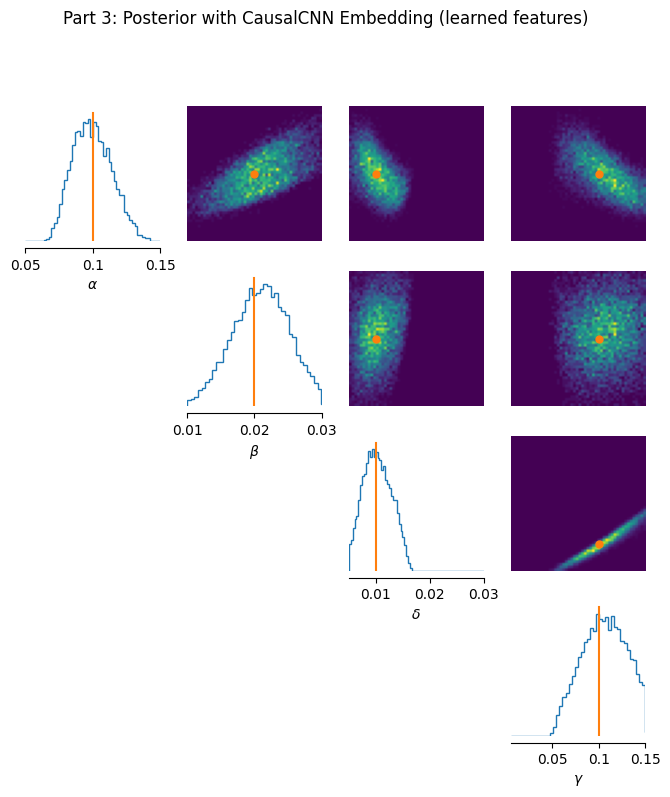

In [20]:
# Pairplot for Part 3: CausalCNN Embedding
fig, axes = pairplot(
    samples_cnn,
    limits=limits,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,
)
plt.suptitle("Part 3: Posterior with CausalCNN Embedding (learned features)", y=1.02)
plt.show()

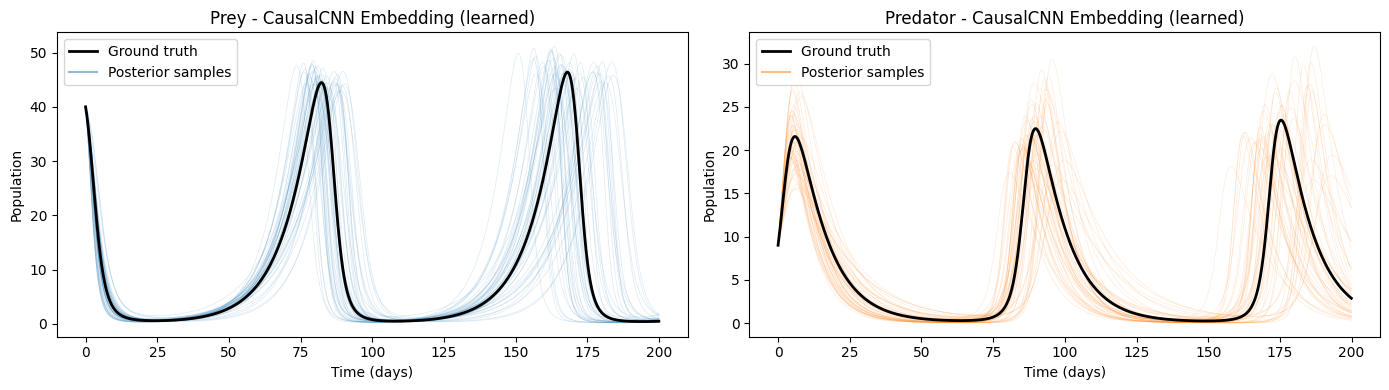

The CausalCNN network learned to extract relevant features from raw time series!
No hand-crafted summary statistics needed.


In [21]:
# Posterior Predictive Check for Part 3
plot_posterior_predictive(
    samples_cnn, theta_o, ts_observed, time,
    n_samples=50, title="CausalCNN Embedding (learned)"
)
print("The CausalCNN network learned to extract relevant features from raw time series!")
print("No hand-crafted summary statistics needed.")

---
## Comparing All Three Approaches

Now let's visualize and compare the posteriors from all three methods!

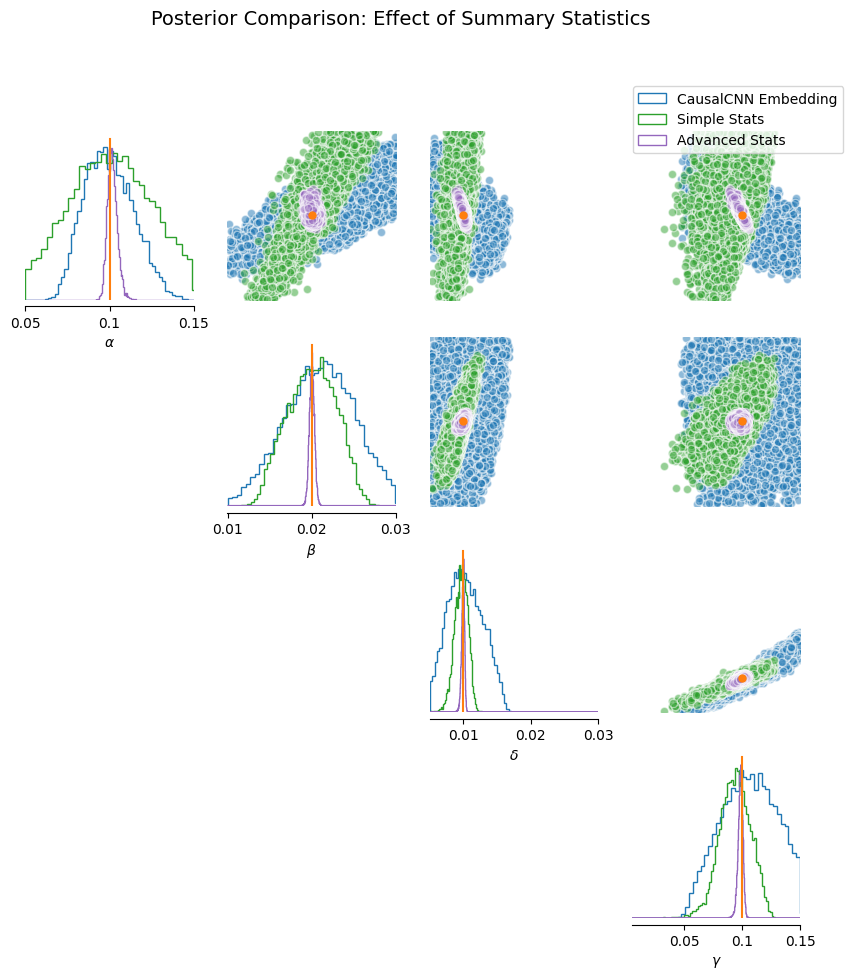

In [25]:
# Detailed pairplot comparison
fig, axes = pairplot(
    [samples_cnn ,samples_simple, samples_advanced],
    limits=limits,
    labels=param_labels,
    figsize=(10, 10),
    points=theta_o,
    diag="hist",
    upper="scatter",
)
# Add legend manually
fig.legend(
    ["CausalCNN Embedding", "Simple Stats", "Advanced Stats"],
    loc="upper right",
    bbox_to_anchor=(0.95, 0.95),
)
plt.suptitle("Posterior Comparison: Effect of Summary Statistics", y=1.02, fontsize=14)
plt.show()

---
## Summary

### Key Takeaways

| Approach | Summary Stats | Pros | Cons |
|----------|---------------|------|------|
| **Simple** | Mean, std, max, skew, kurtosis | Fast, interpretable | Misses temporal structure |
| **Advanced** | + Autocorrelation lags | Captures oscillations | Requires domain knowledge |
| **Neural (CausalCNN)** | Learned from data | No hand-crafting needed | More training data required |

### The `sbi` Pattern for Embedding Networks

```python
# 1. Create embedding network
embedding_net = CausalCNNEmbedding(input_shape=(...,), in_channels=..., output_dim=...)

# 2. Create density estimator with embedding
density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)

# 3. Create inference object
inferer = NPE(prior=prior, density_estimator=density_estimator)

# 4. Train (embedding and flow learned jointly!)
inferer.append_simulations(theta, x).train()
```

### Main Insights

1. **Summary statistics matter!** The choice of summary statistics dramatically affects inference quality.

2. **Domain knowledge helps**: Adding autocorrelation (which captures temporal dynamics) significantly improves inference for oscillatory systems.

3. **Neural embeddings are powerful**: When you don't know the "right" summary statistics, let a neural network learn them!

4. **Trade-offs exist**:
   - Simple stats: Fast and interpretable, but may lose information
   - Neural embeddings: Flexible, but need more data and computation

### When to Use What

- **Simple statistics**: Quick prototyping, well-understood systems
- **Domain-specific statistics**: When you know what features matter
- **Neural embeddings**: Complex data (images, time series), unknown optimal summaries

For more details, see the [sbi tutorial on embedding networks](https://sbi.readthedocs.io/en/stable/advanced_tutorials/04_embedding_networks.html) and [CausalCNNEmbedding source](https://github.com/sbi-dev/sbi/blob/main/sbi/neural_nets/embedding_nets/causal_cnn.py).

---
## Learning Goals

After completing this notebook, you should be able to:

- ✅ Explain why summary statistics are important in SBI
- ✅ Compare the effect of different summary statistics on inference quality
- ✅ Use autocorrelation features for time series data
- ✅ Implement neural embedding networks (CausalCNN) for learning summary statistics
- ✅ Make informed decisions about which summary statistics to use for your problem